In [4]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
import logging
import matplotlib.pyplot as plt
from config.settings import *

logging.basicConfig(level=print, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"

from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiomicTransformerDataset

experiment = "model_training_014"
SELECTED_EXPERIMENT_DIR = OUTPUT_DIR / experiment

GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "ground_truth_files")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

In [4]:
moods_df = pd.read_csv(os.path.join(TRAINING_DATA_CACHE, f"{CHROM_ID}_moods_sites.tsv"), sep="\t")
moods_df.head()

,peak_id,TF,pos,logodds,strand
0,chr19:10002721-10003321,AT3G46070.pfm,544.0,4.227416,+
1,chr19:10018579-10019179,AT3G46070.pfm,311.0,4.506142,+
2,chr19:10026872-10027472,AT3G46070.pfm,110.0,4.879858,-
3,chr19:10034796-10035396,AT3G46070.pfm,184.0,5.862968,+
4,chr19:10038006-10038606,AT3G46070.pfm,155.0,4.355038,+


In [5]:
beeline_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
beeline_ground_truth = beeline_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})
beeline_ground_truth

,TF,TG
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3
...,...,...
977836,ZIC3,ZFP36L3
977837,ZIC3,ZFP499
977838,ZIC3,ZFP57
977839,ZIC3,ZFP91


In [6]:
orti_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
orti_ground_truth = orti_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})
orti_ground_truth

,TF,TG
0,ADNP,MIS18BP1
1,ADNP,EXD1
2,ADNP,CHP1
3,ADNP,OSCAR
4,ADNP,NDUFA3
...,...,...
977836,ZIC3,ZFP36L3
977837,ZIC3,ZFP499
977838,ZIC3,ZFP57
977839,ZIC3,ZFP91


In [7]:
rn115_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "rn115_chipseq.tsv"), sep="\t")
rn115_ground_truth = rn115_ground_truth.rename(columns={"sourceName":"TF", "targetName":"TG"})
rn115_ground_truth = rn115_ground_truth[["TF", "TG"]]
rn115_ground_truth

,TF,TG
0,CHD7,APOA1
1,CHD7,ARHGAP26
2,CHD7,ATP11A
3,CHD7,ATP5O
4,CHD7,AXIN1
...,...,...
133970,ESRRB,GNB2
133971,ESRRB,CCDC37
133972,ESRRB,FAM161A
133973,ESRRB,CSF1


In [18]:
chip_atlas_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "chip_atlas_tf_peak_tg_dist.csv"), header=0, index_col=None)
chip_atlas_ground_truth = chip_atlas_ground_truth.loc[chip_atlas_ground_truth.groupby(["source_id", "peak_id"])["distance"].idxmin()]
chip_atlas_ground_truth = chip_atlas_ground_truth[["source_id", "target_id"]].drop_duplicates()
chip_atlas_ground_truth = chip_atlas_ground_truth.rename(columns={"source_id":"TF", "target_id":"TG"})
chip_atlas_ground_truth.head()


,TF,TG
823560,ASCL1,RASSF9
836912,ASCL1,9230102K24RIK
846448,ASCL1,GM15723
848720,ASCL1,A930009A15RIK
849218,ASCL1,TSPAN8


In [15]:
combined_ground_truth = pd.concat([beeline_ground_truth, orti_ground_truth, rn115_ground_truth, chip_atlas_ground_truth]).drop_duplicates()
combined_ground_truth["TF"] = combined_ground_truth["TF"].str.capitalize()
combined_ground_truth["TG"] = combined_ground_truth["TG"].str.capitalize()
combined_ground_truth.to_csv(os.path.join(GROUND_TRUTH_DIR, "combined_ground_truth"), index=None, header=True)

NameError: name 'beeline_ground_truth' is not defined

In [20]:
combined_ground_truth.head()

,TF,TG
0,Adnp,Mis18bp1
1,Adnp,Exd1
2,Adnp,Chp1
3,Adnp,Oscar
4,Adnp,Ndufa3


In [21]:
combined_ground_truth.shape

(1665765, 2)

In [12]:
gene_near_peaks_df = pd.read_parquet(os.path.join(SAMPLE_CHROM_SPECIFIC_DATA_CACHE_DIR, F"genes_near_peaks_{CHROM_ID}.parquet"))
training_log_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "training_log.csv"), header=0)

In [6]:
from scipy.stats import pearsonr
def plot_per_gene_correlation_scatterplot(model, dataloader, gpu_id=0, outpath=None):
    model.eval()
    preds, tgts = [], []
    with torch.no_grad():
        for atac_wins, tf_tensor, targets, bias in dataloader:
            atac_wins, tf_tensor, targets, bias = (
                atac_wins.to(gpu_id),
                tf_tensor.to(gpu_id),
                targets.to(gpu_id),
                bias.to(gpu_id)
            )
            output = model(atac_wins, tf_tensor)
            preds.append(output.cpu().numpy())
            tgts.append(targets.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    tgts  = np.concatenate(tgts, axis=0)

    # inverse-transform
    # preds_rescaled = scaler.inverse_transform(preds)
    # tgts_rescaled  = scaler.inverse_transform(tgts)
    preds_rescaled = preds
    tgts_rescaled  = tgts

    corr, _ = pearsonr(preds_rescaled.ravel(), tgts_rescaled.ravel())
    print(f"Test Pearson correlation: {corr:.3f}")

    plt.figure(figsize=(6,6))
    plt.scatter(tgts_rescaled, preds_rescaled, alpha=0.5, s=5)
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(f"Predicted vs True (r={corr:.3f})")
    plt.plot([tgts_rescaled.min(), tgts_rescaled.max()],
             [tgts_rescaled.min(), tgts_rescaled.max()], 'r--')
    if outpath:
        plt.savefig(outpath, dpi=300)
    else:
        plt.show()

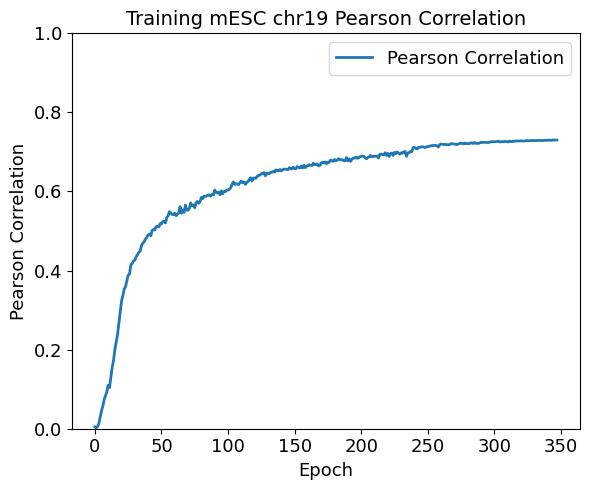

In [13]:
def plot_pearson_corr_across_epochs(df):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df.index, df["Pearson"], linewidth=2, label="Pearson Correlation")

    plt.title(f"Training mESC {CHROM_ID} Pearson Correlation", fontsize=14)
    plt.ylim((0,1))
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.xlabel("Epoch", fontsize=13)
    plt.ylabel("Pearson Correlation", fontsize=13)
    plt.legend(fontsize=13)
    plt.tight_layout()
    
    return fig

fig = plot_pearson_corr_across_epochs(training_log_df)
fig.savefig(os.path.join(OUTPUT_DIR, "eval_results_pearson_corr.png"), dpi=300)
fig.show()

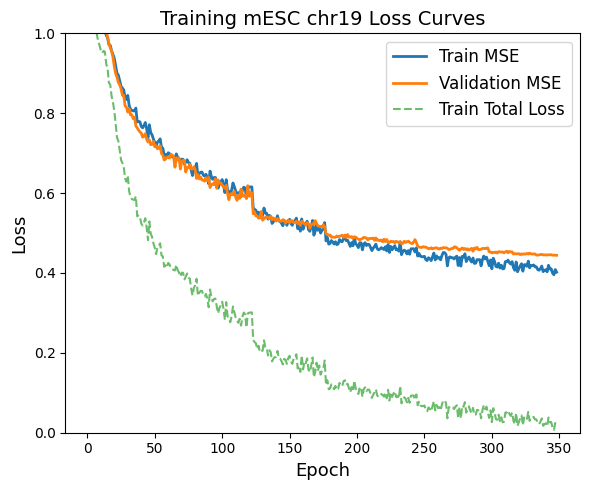

In [14]:
def plot_train_val_loss(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df["Epoch"], df["Train MSE"], label="Train MSE", linewidth=2)
    plt.plot(df["Epoch"], df["Val MSE"], label="Validation MSE", linewidth=2)
    plt.plot(df["Epoch"], df["Train Total Loss"], label="Train Total Loss", linestyle="--", alpha=0.7)

    plt.title(f"Training {dataset_name} {chrom_id} Loss Curves", fontsize=14)
    plt.xlabel("Epoch", fontsize=13)
    plt.ylabel("Loss", fontsize=13)
    plt.ylim([0, 1])
    plt.legend(fontsize=12)
    plt.tight_layout()
    return fig
    
fig = plot_train_val_loss(training_log_df, DATASET_NAME, CHROM_ID)
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_training_loss.png"), dpi=300)
fig.show()

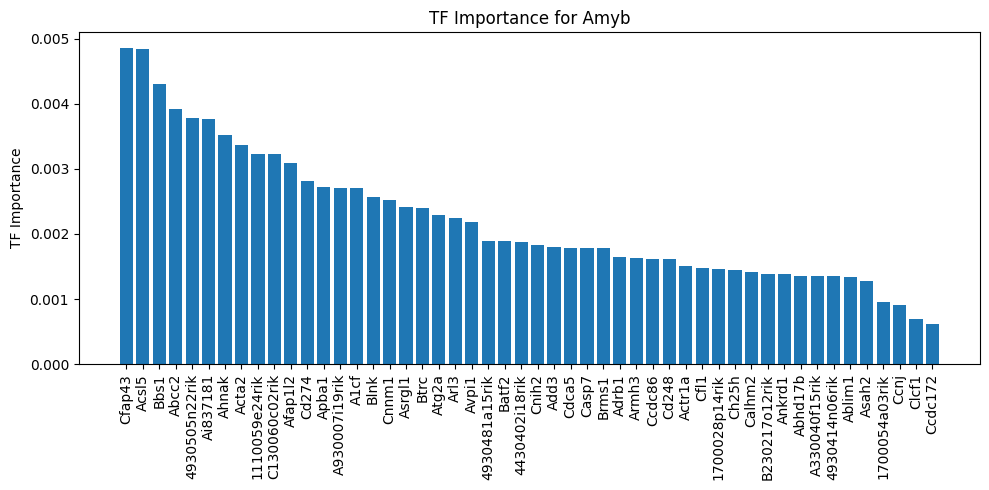

In [ ]:
tf_imp_dir = os.path.join(SELECTED_EXPERIMENT_DIR, "tf_gradient_attributions")
            
tf_importance_df = pd.read_csv(os.path.join(tf_imp_dir, "tf_importance_matrix.csv"), header=0, index_col=0)

fig = plt.figure(figsize=(10,5))

selected_tg = tf_importance_df.index[0]
selected_tf_row = tf_importance_df.iloc[0]
selected_tf_row = selected_tf_row.iloc[:50].sort_values(ascending=False)

plt.xticks(rotation=90, fontsize=10)
plt.bar(x=selected_tf_row.index, height=selected_tf_row)
plt.title(f"TF Importance for {selected_tg}")
plt.ylabel("TF Importance")
plt.tight_layout()
plt.show()

In [48]:
tf_importance_df.head()

,1110059e24rik,1700028p14rik,1700054a03rik,4430402i18rik,4930414n06rik,4930481a15rik,4930505n22rik,A1cf,A330040f15rik,A930007i19rik,...,Trpt1,Tsga10ip,Unc93b1,Vldlr,Vps13a,Vti1a,Vwa2,Wnt8b,Yif1a,Zfand5
Amyb,0.003226,0.001461,0.000959,0.001882,0.001350,0.001891,0.003782,0.002698,0.001352,0.002706,...,0.002073,0.001486,0.001049,0.002824,0.001456,0.002358,0.001064,0.002434,0.002479,0.001562
Ap-1,0.002404,0.001274,0.000866,0.001571,0.000962,0.002013,0.004165,0.002701,0.001321,0.001609,...,0.001974,0.001660,0.001676,0.003604,0.001144,0.002757,0.000689,0.002350,0.002047,0.002187
Atoh1,0.002387,0.002679,0.001652,0.002026,0.001205,0.002540,0.004685,0.002055,0.002184,0.001709,...,0.001736,0.002859,0.001249,0.002320,0.001855,0.004071,0.000805,0.002184,0.003234,0.003685
Hnf4a,0.000716,0.000437,0.000122,0.000522,0.000557,0.000668,0.001463,0.000568,0.000749,0.000579,...,0.000387,0.000934,0.000646,0.000666,0.000302,0.001205,0.000572,0.000786,0.001266,0.000464
Hnf6,0.002877,0.001683,0.001351,0.002000,0.000832,0.001821,0.005402,0.001905,0.002727,0.001037,...,0.000833,0.001845,0.001350,0.004318,0.001334,0.003690,0.001519,0.003182,0.002605,0.003449


In [17]:
def evaluate_chip_aucs(tf_importance_df, chip_df, k_list=(100, 500, 1000, 5000)):
    """
    Evaluate AUROC / PR-AUC / Precision K against CHIP edges.
    We uppercase both the CHIP and the DF indexing to align.
    """
    chip_edges = {(t.upper(), g.upper()) for t, g in zip(chip_df["TF"], chip_df["TG"])}

    # Uppercase DF indexing for matching
    tf_imp = tf_importance_df.copy()
    tf_imp.index   = [x.upper() for x in tf_imp.index]
    tf_imp.columns = [x.upper() for x in tf_imp.columns]

    rn111_tfs = {t for t, _ in chip_edges}
    rn111_tgs = {g for _, g in chip_edges}

    tf_imp = tf_imp.loc[tf_imp.index.intersection(rn111_tfs),
                        tf_imp.columns.intersection(rn111_tgs)]
    if tf_imp.empty:
        raise ValueError("No overlap between TF/TG names and CHIP set.")

    scores, labels, edges = [], [], []
    # Flatten
    for tg in tf_imp.columns:
        col = tf_imp[tg]
        for tf, score in col.items():
            scores.append(float(score))
            labels.append(1 if (tf, tg) in chip_edges else 0)
            edges.append((tf, tg))

    if len(set(labels)) < 2:
        raise ValueError("Only one class present after overlap; AUROC/PR-AUC undefined.")

    auroc = roc_auc_score(labels, scores)
    auprc = average_precision_score(labels, scores)

    # Precision K
    df_scored = pd.DataFrame(edges, columns=["tf", "tg"])
    df_scored["score"] = scores
    df_scored["label"] = labels
    df_scored = df_scored.sort_values("score", ascending=False).reset_index(drop=True)

    results = {"AUROC": auroc, "PR-AUC": auprc, "positives": int(sum(labels)), "edges": int(len(labels))}
    for k in k_list:
        k = int(k)
        if k <= len(df_scored):
            prec_k = df_scored.head(k)["label"].mean()
            results[f"Precision@{k}"] = float(prec_k)

    return results, df_scored

results, df_scored = evaluate_chip_aucs(tf_importance_df, beeline_ground_truth, k_list=(100, 500, 1000, 5000))

print(f"AUROC = {results['AUROC']:.4f}  |  PR-AUC = {results['PR-AUC']:.4f}  "
        f"| positives={results['positives']} / {results['edges']} edges")
for k in (100, 500, 1000, 5000):
    key = f"AUROC@{k}"
    if key in results:
        print(f"{key}: {results[key]:.3f}")


NameError: name 'tf_importance_df' is not defined

In [16]:
tf_tg_pred = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "tf_gradient_attributions/scored_edges.tsv"), sep="\t", header=0, index_col=None)
tf_tg_pred.head()

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC/chr19/model_training_014/tf_gradient_attributions/scored_edges.tsv'

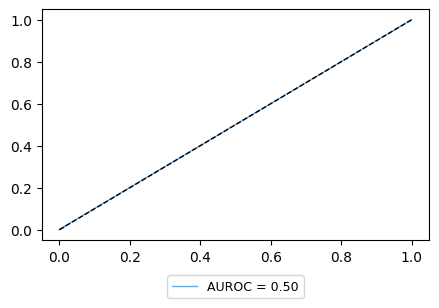

In [52]:
from dev.notebooks.plotting import (
    plot_true_false_distribution, plot_true_false_boxplots, plot_true_false_scores_by_tf_boxplots,
    plot_true_false_scores_by_tf_barplots, plot_auroc
)

fig = plot_auroc(tf_tg_pred, score_col="score")
fig.show()

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


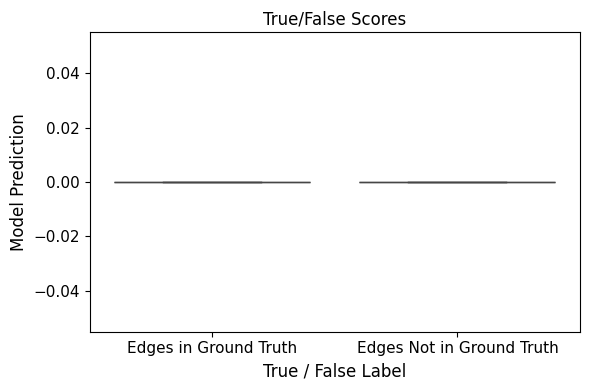

In [51]:
fig = plot_true_false_boxplots(
    df=tf_tg_pred,
    score_col="score",
    xlabel="True / False Label",
    ylabel = "Model Prediction"
    )

In [21]:
import importlib
import dev.notebooks.plotting
importlib.reload(dev.notebooks.plotting)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

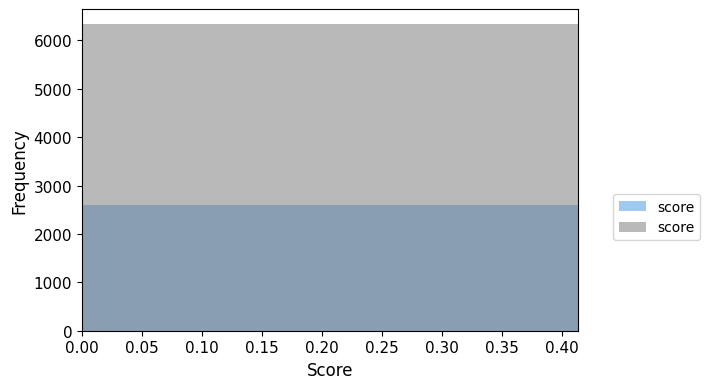

In [ ]:
fig = plot_true_false_distribution(
    true_series=tf_tg_pred[tf_tg_pred["label"] == 1]["score"],
    false_series=tf_tg_pred[tf_tg_pred["label"] == 0]["score"],
    )